In [1]:
import psycopg2

postgres_connection = psycopg2.connect(
    database='kratos',
    host='localhost',
    user='serlo',
    password='secret',
)

In [2]:
import pandas as pd

def get_registrations(query):
    cursor = postgres_connection.cursor()
    cursor.execute(query)
    dates_and_registrations = cursor.fetchall()
    df = pd.DataFrame(dates_and_registrations, columns=['registration_day', 'num_registrations'])
    df['registration_day'] = pd.to_datetime(df['registration_day'])
    if df.index[-1] != pd.to_datetime('today').normalize():
        df.loc[-1] = [pd.to_datetime('today').normalize(), 0]
    return df.set_index('registration_day').resample('D').sum().fillna(value=0)

user_registrations = get_registrations(
    """
    SELECT DATE_TRUNC('day', created_at) AS registration_day, COUNT(*) 
    FROM identities
    WHERE created_at >= CURRENT_DATE - INTERVAL '1 year'
    GROUP BY registration_day
    ORDER BY registration_day
    """
    )

users_registered_that_logged_in_again_on_a_different_day = get_registrations(
    """
    SELECT DATE_TRUNC('day', created_at) AS registration_day, COUNT(*) 
    FROM identities
    WHERE created_at >= CURRENT_DATE - INTERVAL '1 year'
    AND (metadata_public->>'lastLogin') IS NOT NULL
    AND (metadata_public->>'lastLogin')::date > created_at::date
    GROUP BY registration_day
    ORDER BY registration_day;
    """
    )

Note that saving the last login was broken before mid October 2023!
See https://github.com/serlo/api.serlo.org/pull/794.
For example, a user who registered in May 2023 and only returned in June and July of the same year cannot be detected as returning user!



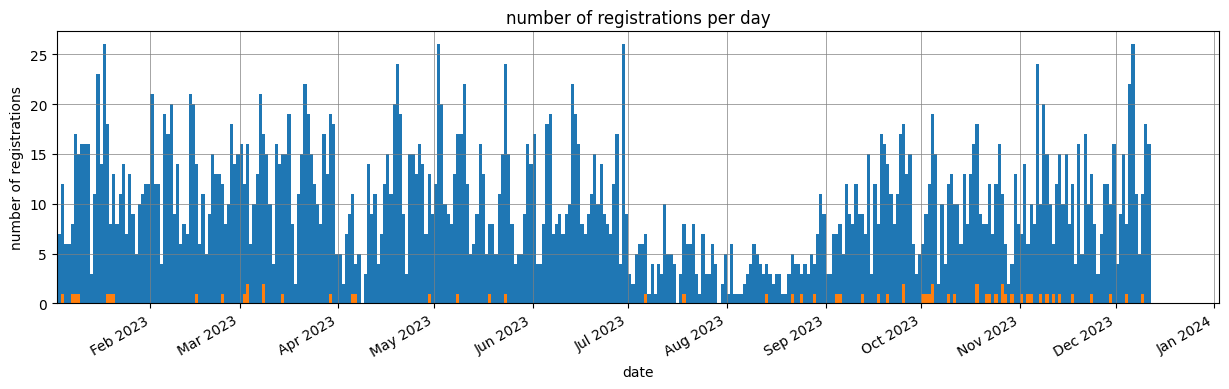

In [3]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("""Note that saving the last login was broken before mid October 2023!
See https://github.com/serlo/api.serlo.org/pull/794.
For example, a user who registered in May 2023 and only returned in June and July of the same year cannot be detected as returning user!
""")

def plot_dataframe(df):
    df.reset_index()
    days = df.reset_index()['registration_day'].tolist()
    registrations = df['num_registrations'].tolist()
    plt.bar(days, registrations, width=1, align='edge')
    return (days, registrations)

plt.figure(figsize=(15, 4))
plot_dataframe(user_registrations)
plot_dataframe(users_registered_that_logged_in_again_on_a_different_day)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xlabel('date')
today = datetime.today()
plt.xlim([today-timedelta(365), today])
plt.ylabel('number of registrations')
plt.title('number of registrations per day')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

In [4]:
import mysql.connector

mysql_connection = mysql.connector.connect(
    database="serlo",
    host="localhost",
    user="root",
    password="secret",
    port="3306"
)

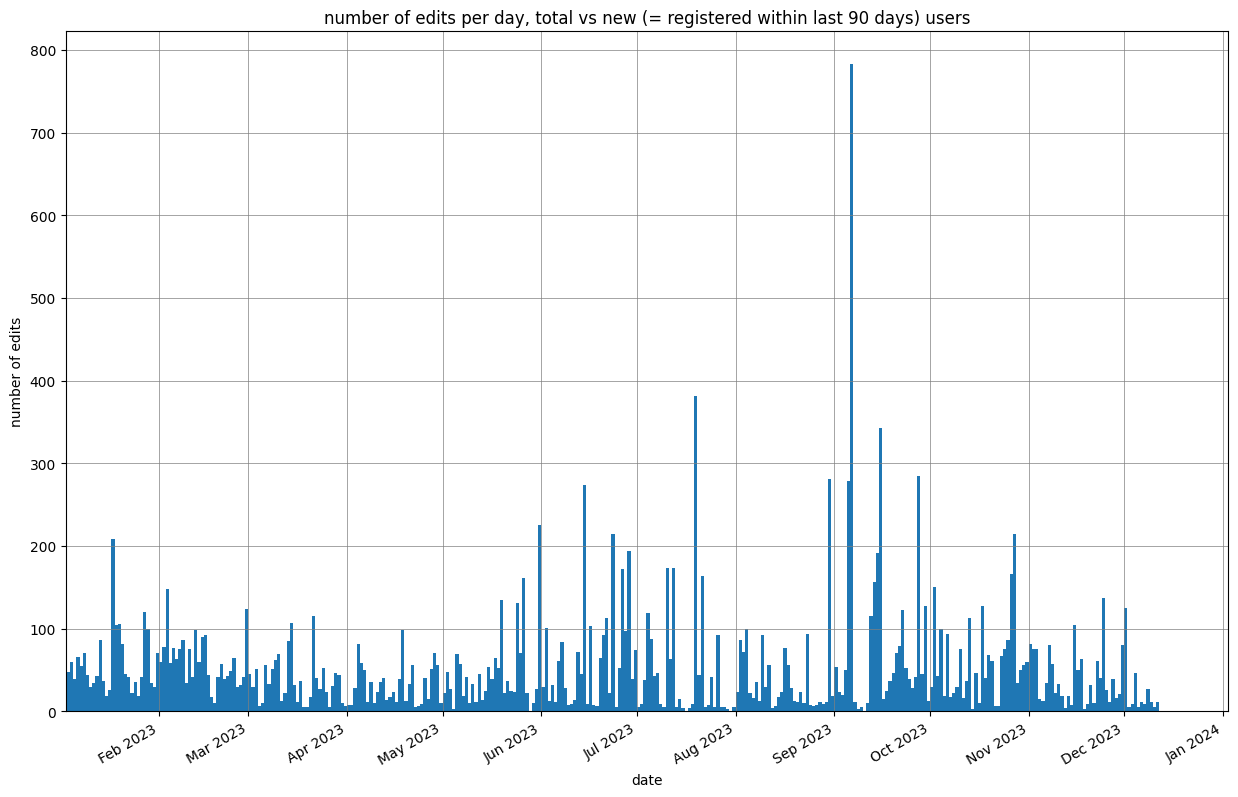

In [15]:
# get total edits per day
query = """
SELECT DATE(date) AS edit_day, COUNT(*) 
FROM event_log
JOIN event ON event_log.event_id = event.id
WHERE date >= CURRENT_DATE - INTERVAL 1 year
AND event.name = 'entity/revision/add' -- assuming that an added revision is the same as an edit
-- todo: check if we need something like AND actor_id != uuid_serlobot
GROUP BY edit_day
ORDER BY edit_day
"""
# Query to check that the edit peak is actually real users not the Serlo bot:
# SELECT actor_id, COUNT(*) AS count FROM event_log WHERE DATE(date) = "2023-09-06" AND event_id = 5 GROUP BY actor_id ORDER BY count DESC LIMIT 3;
cursor = mysql_connection.cursor()
cursor.execute(query)
editor_and_date = cursor.fetchall()
df = pd.DataFrame(editor_and_date, columns=['edit_day', 'num_edits'])
df['edit_day'] = pd.to_datetime(df['edit_day'])
if df.index[-1] != pd.to_datetime('today').normalize():
    df.loc[-1] = [pd.to_datetime('today').normalize(), 0]
edits_per_day = df.set_index('edit_day').resample('D').sum().fillna(value=0)

def plot_dataframe(df):
    df.reset_index()
    days = df.reset_index()['edit_day'].tolist()
    edits = df['num_edits'].tolist()
    plt.bar(days, edits, width=1, align='edge')
    return (days, edits)

plt.figure(figsize=(15, 10))
plot_dataframe(edits_per_day)
#plot_dataframe(edits_by_new_usersper_day)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xlabel('date')
today = datetime.today()
plt.xlim([today-timedelta(365), today])
plt.ylabel('number of edits')
plt.title('number of edits per day, total vs new (= registered within last 90 days) users')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

# get user and date for all edits (entity/revision/add)
query = """
SELECT actor_id, date FROM event_log
"""
cursor = mysql_connection.cursor()
cursor.execute(query)
editor_and_date = cursor.fetchall()